<a href="https://colab.research.google.com/github/Vishal-Sharma7/Image-restoration-and-video-enhancement/blob/main/LLIE_image_and_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows the TensorFlow model conversion and inference processes for the **LLIE** model as proposed by [research paper name](https://). This model is capable of enhancing low-light images upto a great extent.

<p align="center">
<img src="https://github.com/"</img><br>
<small><a href="https://github.com/">Source</a></small>
</p>

Model training code and pre-trained weights are provided by **Vaibhav** through [this repository](https://github.com/).

Access **Ritik's** notebooks  [here](https://github.com/).

## Initial setup

In [ ]:
!pip install tensorflow

In [ ]:
!nvidia-smi

Sun May 19 11:20:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from glob import glob
import os
import tensorflow as tf
from typing import List

import keras
from keras.optimizers import Adam


In [ ]:
!pip install -q wandb

In [ ]:
from wandb.integration.keras import WandbCallback

In [ ]:

import gdown
import wandb
import subprocess
from matplotlib import pyplot as plt

In [ ]:
def read_images(image_files):
    dataset = tf.data.Dataset.from_tensor_slices(image_files)
    dataset = dataset.map(tf.io.read_file)
    dataset = dataset.map(
        lambda x: tf.image.decode_png(x, channels=3),
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    return dataset


def random_crop(low_image, enhanced_image, low_crop_size, enhanced_crop_size):
    low_image_shape = tf.shape(low_image)[:2]
    low_w = tf.random.uniform(
        shape=(), maxval=low_image_shape[1] - low_crop_size + 1, dtype=tf.int32)
    low_h = tf.random.uniform(
        shape=(), maxval=low_image_shape[0] - low_crop_size + 1, dtype=tf.int32)
    enhanced_w = low_w
    enhanced_h = low_h
    low_image_cropped = low_image[
                        low_h:low_h + low_crop_size,
                        low_w:low_w + low_crop_size
                        ]
    enhanced_image_cropped = enhanced_image[
                             enhanced_h:enhanced_h + enhanced_crop_size,
                             enhanced_w:enhanced_w + enhanced_crop_size
                             ]
    return low_image_cropped, enhanced_image_cropped


def random_flip(low_image, enhanced_image):
    return tf.cond(
        tf.random.uniform(shape=(), maxval=1) < 0.5,
        lambda: (low_image, enhanced_image),
        lambda: (
            tf.image.flip_left_right(low_image),
            tf.image.flip_left_right(enhanced_image)
        )
    )


def random_rotate(low_image, enhanced_image):
    condition = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    return tf.image.rot90(low_image, condition), tf.image.rot90(enhanced_image, condition)


def apply_scaling(low_image, enhanced_image):
    low_image = tf.cast(low_image, tf.float32)
    enhanced_image = tf.cast(enhanced_image, tf.float32)
    low_image = low_image / 255.0
    enhanced_image = enhanced_image / 255.0
    return low_image, enhanced_image


In [ ]:
class LOLDataLoader:

    def __init__(self, images_lowlight: List[str], images_highlight: List[str]):
        self.images_lowlight = images_lowlight
        self.images_highlight = images_highlight

    def __len__(self):
        assert len(self.images_lowlight) == len(self.images_enhanced)
        return len(self.images_lowlight)

    def build_dataset(self, image_crop_size: int, batch_size: int, is_dataset_train: bool):
        low_light_dataset = read_images(self.images_lowlight)
        high_light_dataset = read_images(self.images_highlight)
        dataset = tf.data.Dataset.zip((low_light_dataset, high_light_dataset))
        dataset = dataset.map(apply_scaling, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.map(
            lambda low, high: random_crop(low, high, image_crop_size, image_crop_size),
            num_parallel_calls=tf.data.experimental.AUTOTUNE
        )
        if is_dataset_train:
            dataset = dataset.map(random_rotate, num_parallel_calls=tf.data.experimental.AUTOTUNE)
            dataset = dataset.map(random_flip, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(batch_size)
        dataset = dataset.repeat(1)
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return dataset


In [ ]:

def spatial_attention_block(input_tensor):
    """Spatial Attention Block"""
    average_pooling = tf.reduce_max(input_tensor, axis=-1)
    average_pooling = tf.expand_dims(average_pooling, axis=-1)
    max_pooling = tf.reduce_mean(input_tensor, axis=-1)
    max_pooling = tf.expand_dims(max_pooling, axis=-1)
    concatenated = tf.keras.layers.Concatenate(axis=-1)([average_pooling, max_pooling])
    feature_map = tf.keras.layers.Conv2D(1, kernel_size=(1, 1))(concatenated)
    feature_map = tf.nn.sigmoid(feature_map)
    return input_tensor * feature_map


def channel_attention_block(input_tensor):
    """Channel Attention Block"""
    channels = list(input_tensor.shape)[-1]
    average_pooling = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
    feature_descriptor = tf.reshape(average_pooling, shape=(-1, 1, 1, channels))
    feature_activations = tf.keras.layers.ReLU()(
        tf.keras.layers.Conv2D(
            filters=channels // 8, kernel_size=(1, 1)
        )(feature_descriptor)
    )
    feature_activations = tf.nn.sigmoid(
        tf.keras.layers.Conv2D(
            filters=channels, kernel_size=(1, 1)
        )(feature_activations)
    )
    return input_tensor * feature_activations

In [ ]:
def dual_attention_unit_block(input_tensor):
    """Dual Attention Unit Block"""
    channels = list(input_tensor.shape)[-1]
    feature_map = tf.keras.layers.Conv2D(
        channels, kernel_size=(3, 3), padding='same')(input_tensor)
    feature_map = tf.keras.layers.ReLU()(feature_map)
    feature_map = tf.keras.layers.Conv2D(
        channels, kernel_size=(3, 3), padding='same')(feature_map)
    channel_attention = channel_attention_block(feature_map)
    spatial_attention = spatial_attention_block(feature_map)
    concatenation = tf.keras.layers.Concatenate(axis=-1)([
        channel_attention, spatial_attention])
    concatenation = tf.keras.layers.Conv2D(channels, kernel_size=(1, 1))(concatenation)
    return tf.keras.layers.Add()([input_tensor, concatenation])


def selective_kernel_feature_fusion(
        multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3):
    """Selective Kernel Feature Fusion Block"""
    channels = list(multi_scale_feature_1.shape)[-1]
    combined_feature = tf.keras.layers.Add()([
        multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3])
    gap = tf.keras.layers.GlobalAveragePooling2D()(combined_feature)
    channel_wise_statistics = tf.reshape(gap, shape=(-1, 1, 1, channels))
    compact_feature_representation = tf.keras.layers.ReLU()(
        tf.keras.layers.Conv2D(
            filters=channels // 8, kernel_size=(1, 1)
        )(channel_wise_statistics)
    )
    feature_descriptor_1 = tf.nn.softmax(
        tf.keras.layers.Conv2D(channels, kernel_size=(1, 1))(compact_feature_representation)
    )
    feature_descriptor_2 = tf.nn.softmax(
        tf.keras.layers.Conv2D(channels, kernel_size=(1, 1))(compact_feature_representation)
    )
    feature_descriptor_3 = tf.nn.softmax(
        tf.keras.layers.Conv2D(channels, kernel_size=(1, 1))(compact_feature_representation)
    )
    feature_1 = multi_scale_feature_1 * feature_descriptor_1
    feature_2 = multi_scale_feature_2 * feature_descriptor_2
    feature_3 = multi_scale_feature_3 * feature_descriptor_3
    aggregated_feature = tf.keras.layers.Add()([feature_1, feature_2, feature_3])
    return aggregated_feature

def down_sampling_module(input_tensor):
    """Downsampling Module"""
    channels = list(input_tensor.shape)[-1]
    main_branch = tf.keras.layers.Conv2D(
        channels, kernel_size=(1, 1))(input_tensor)
    main_branch = tf.nn.relu(main_branch)
    # main_branch = tf.keras.layers.Conv2D(
    #     channels, kernel_size=(3, 3), padding='same')(input_tensor)
    main_branch = tf.keras.layers.Conv2D(
        channels, kernel_size=(3, 3), padding='same')(main_branch)
    main_branch = tf.nn.relu(main_branch)
    main_branch = tf.keras.layers.MaxPooling2D()(main_branch)
    main_branch = tf.keras.layers.Conv2D(
        channels * 2, kernel_size=(1, 1))(main_branch)
    skip_branch = tf.keras.layers.MaxPooling2D()(input_tensor)
    skip_branch = tf.keras.layers.Conv2D(
        channels * 2, kernel_size=(1, 1))(skip_branch)
    return tf.keras.layers.Add()([skip_branch, main_branch])


def up_sampling_module(input_tensor):
    """Upsampling Module"""
    channels = list(input_tensor.shape)[-1]
    main_branch = tf.keras.layers.Conv2D(
        channels, kernel_size=(1, 1))(input_tensor)
    main_branch = tf.nn.relu(main_branch)
    # main_branch = tf.keras.layers.Conv2D(
    #     channels, kernel_size=(3, 3), padding='same')(input_tensor)
    main_branch = tf.keras.layers.Conv2D(
        channels, kernel_size=(3, 3), padding='same')(main_branch)
    main_branch = tf.nn.relu(main_branch)
    main_branch = tf.keras.layers.UpSampling2D()(main_branch)
    main_branch = tf.keras.layers.Conv2D(
        channels // 2, kernel_size=(1, 1))(main_branch)
    skip_branch = tf.keras.layers.UpSampling2D()(input_tensor)
    skip_branch = tf.keras.layers.Conv2D(
        channels // 2, kernel_size=(1, 1))(skip_branch)
    return tf.keras.layers.Add()([skip_branch, main_branch])


In [ ]:
def multi_scale_residual_block(input_tensor, channels):
    # features
    level1 = input_tensor
    level2 = down_sampling_module(input_tensor)
    level3 = down_sampling_module(level2)
    # DAU
    level1_dau = dual_attention_unit_block(level1)
    level2_dau = dual_attention_unit_block(level2)
    level3_dau = dual_attention_unit_block(level3)
    # SKFF
    level1_skff = selective_kernel_feature_fusion(
        level1_dau, up_sampling_module(level2_dau),
        up_sampling_module(up_sampling_module(level3_dau))
    )
    level2_skff = selective_kernel_feature_fusion(
        down_sampling_module(level1_dau), level2_dau,
        up_sampling_module(level3_dau)
    )
    level3_skff = selective_kernel_feature_fusion(
        down_sampling_module(down_sampling_module(level1_dau)),
        down_sampling_module(level2_dau), level3_dau
    )
    # DAU 2
    level1_dau_2 = dual_attention_unit_block(level1_skff)
    level2_dau_2 = up_sampling_module((dual_attention_unit_block(level2_skff)))
    level3_dau_2 = up_sampling_module(up_sampling_module(dual_attention_unit_block(level3_skff)))
    # SKFF 2
    # skff_ = selective_kernel_feature_fusion(level1_dau_2, level3_dau_2, level3_dau_2)
    skff_ = selective_kernel_feature_fusion(level1_dau_2, level2_dau_2, level3_dau_2)
    conv = tf.keras.layers.Conv2D(channels, kernel_size=(3, 3), padding='same')(skff_)
    return tf.keras.layers.Add()([input_tensor, conv])



def recursive_residual_group(input_tensor, num_mrb, channels):
    conv1 = tf.keras.layers.Conv2D(
        channels, kernel_size=(3, 3), padding='same')(input_tensor)
    for _ in range(num_mrb):
        conv1 = multi_scale_residual_block(conv1, channels)
    conv2 = tf.keras.layers.Conv2D(
        channels, kernel_size=(3, 3), padding='same')(conv1)
    return tf.keras.layers.Add()([conv2, input_tensor])


def mirnet_model(image_size: int, num_rrg: int, num_mrb: int, channels: int):
    input_tensor = tf.keras.Input(shape=[image_size, image_size, 3])
    x1 = tf.keras.layers.Conv2D(
        channels, kernel_size=(3, 3), padding='same')(input_tensor)
    for _ in range(num_rrg):
        x1 = recursive_residual_group(x1, num_mrb, channels)
    conv = tf.keras.layers.Conv2D(
        3, kernel_size=(3, 3), padding='same')(x1)
    output_tensor = tf.keras.layers.Add()([input_tensor, conv])
    return tf.keras.Model(input_tensor, output_tensor)


In [ ]:

def psnr(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=255.0)

def ssim(y_true, y_pred):
    return tf.image.ssim(y_pred, y_true, max_val=255.0)


def init_wandb(project_name, experiment_name, wandb_api_key):
    """Initialize Wandb
    Args:
        project_name: project name on Wandb
        experiment_name: experiment name on Wandb
        wandb_api_key: Wandb API Key
    """
    if project_name is not None and experiment_name is not None:
        os.environ['WANDB_API_KEY'] = wandb_api_key
        wandb.init(project=project_name, name=experiment_name)


def download_dataset(dataset_tag):
    """Utility for downloading and unpacking dataset dataset
    Args:
        dataset_tag: Tag for the respective dataset.
        Available tags -> ('LOL')
    """
    print('Downloading dataset...')
    if dataset_tag == 'LOL':
        gdown.download(
            # 'https://drive.google.com/uc?id=157bjO1_cFuSd0HWDUuAmcHRJDVyWpOxB',
            'https://drive.google.com/uc?id=157bjO1_cFuSd0HWDUuAmcHRJDVyWpOxB',
            'LOLdataset.zip', quiet=False
        )
        print('Unpacking Dataset')
        subprocess.run(['unzip', 'LOLdataset.zip'])
        print('Done!!!')
    else:
        raise AssertionError('Dataset tag not found')


def plot_result(image, enhanced):
    """Utility for Plotting inference result
    Args:
        image: original image
        enhanced: enhanced image
    """
    fig = plt.figure(figsize=(12, 12))
    fig.add_subplot(1, 2, 1).set_title('Original Image')
    _ = plt.imshow(image)
    fig.add_subplot(1, 2, 2).set_title('Enhanced Image')
    _ = plt.imshow(enhanced)
    plt.show()


def closest_number(n, m):
    q = int(n / m)
    n1 = m * q
    if (n * m) > 0:
        n2 = (m * (q + 1))
    else:
        n2 = (m * (q - 1))
    if abs(n - n1) < abs(n - n2):
        return n1
    return n2


def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(
        tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3))
    )


In [ ]:
class LowLightTrainer:

    def __init__(self):
        self.model = None
        self.crop_size = None
        self.train_dataset = None
        self.valid_dataset = None
        self.new_model = None
        # self.strategy = tf.distribute.OneDeviceStrategy("GPU:0")
        # if len(tf.config.list_physical_devices('GPU')) > 1:
        #     self.strategy = tf.distribute.MirroredStrategy()

    def build_dataset(
            self, train_low_light_images: List[str], train_high_light_images: List[str],
            valid_low_light_images: List[str], valid_high_light_images: List[str],
            crop_size: int, batch_size: int):
        self.crop_size = crop_size
        self.train_dataset = LOLDataLoader(
            images_lowlight=train_low_light_images,
            images_highlight=train_high_light_images
        ).build_dataset(
            image_crop_size=crop_size, batch_size=batch_size, is_dataset_train=True)
        self.valid_dataset = LOLDataLoader(
            images_lowlight=valid_low_light_images,
            images_highlight=valid_high_light_images
        ).build_dataset(
            image_crop_size=crop_size, batch_size=batch_size, is_dataset_train=False)

    def compile(self, num_rrg=3, num_mrb=2, channels=64, learning_rate=1e-4, use_mae_loss=True):
        self.model = mirnet_model(self.crop_size, num_rrg, num_mrb, channels)
        loss_function = keras.losses.MeanAbsoluteError() if use_mae_loss else charbonnier_loss
        # optimizer = Adam(learning_rate=learning_rate)
        # optimizer = Adam()
        optimizer = tf.keras.optimizers.Adam()
        self.model.compile(optimizer=optimizer, loss=loss_function, metrics=[psnr,ssim])

    def train(self, epochs: int, checkpoint_dir: str):
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor="val_psnr",
                patience=10, mode='max'
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_psnr', factor=0.5,
                patience=5, verbose=1, min_delta=1e-7, mode='max'
            ),
            keras.callbacks.ModelCheckpoint(
                os.path.join(checkpoint_dir, 'low_light_weights_best.h5'),
                monitor="val_psnr", save_weights_only=True,
                mode="max", save_best_only=True, save_freq=1
            ),
            WandbCallback()
        ]
        history = self.model.fit(
            self.train_dataset, validation_data=self.valid_dataset,
            epochs=epochs, callbacks=callbacks, verbose=1
        )
        return history

    def save_model(self, model_path: str):
      # from keras.models import save_model
      self.model.save(model_path)

    # def load(self, dir: str):
    #   from keras.models import load_model
    #   self.new_model.load_model(dir)

    def save_weight(self, checkpoint: str):
      self.model.save_weights("/content/drive/MyDrive/minor/low_light_weights_best.h5")


## Download dataset and pre-trained weights

In [ ]:
!pip install Pillow

In [ ]:
from PIL import Image
import numpy as np

class Inferer:

    def __init__(self):
        self.model = None

    @staticmethod
    def download_weights(file_id: str):
        gdown.download(
            'https://drive.google.com/uc?id={}'.format(file_id),
            'low_light_weights_best.h5', quiet=False
        )

    def build_model(self, num_rrg: int, num_mrb: int, channels: int, weights_path: str):
        self.model = mirnet_model(
            image_size=None, num_rrg=num_rrg,
            num_mrb=num_mrb, channels=channels
        )
        self.model.load_weights(weights_path)

    def _predict(self, original_image, image_resize_factor: float = 1.):
        width, height = original_image.size
        target_width, target_height = (
            closest_number(width // image_resize_factor, 4),
            closest_number(height // image_resize_factor, 4)
        )
        original_image = original_image.resize(
            (target_width, target_height), Image.ANTIALIAS
        )
        image = tf.keras.preprocessing.image.img_to_array(original_image)
        image = image.astype('float32') / 255.0
        image = np.expand_dims(image, axis=0)
        output = self.model.predict(image)
        output_image = output[0] * 255.0
        output_image = output_image.clip(0, 255)
        output_image = output_image.reshape(
            (np.shape(output_image)[0], np.shape(output_image)[1], 3)
        )
        output_image = Image.fromarray(np.uint8(output_image))
        original_image = Image.fromarray(np.uint8(original_image))
        return output_image

    def infer(self, image_path, image_resize_factor: float = 1.):
        original_image = Image.open(image_path)
        output_image = self._predict(original_image, image_resize_factor)
        return original_image, output_image

    def infer_streamlit(self, image_pil, image_resize_factor: float = 1.):
        original_image = image_pil
        output_image = self._predict(original_image, image_resize_factor)
        return original_image, output_image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
inferer = Inferer()
inferer.download_weights('1-MtkEzu4aA6qRqgO7z2uregomid79AbJ')
inferer.build_model(
    num_rrg=3, num_mrb=2, channels=64,
    weights_path='/content/drive/MyDrive/minor/low_light_weights_best.h5'
)
inferer.model.summary()

Downloading...
From (original): https://drive.google.com/uc?id=1-MtkEzu4aA6qRqgO7z2uregomid79AbJ
From (redirected): https://drive.google.com/uc?id=1-MtkEzu4aA6qRqgO7z2uregomid79AbJ&confirm=t&uuid=3c8721ea-83d4-4f33-aecd-90668099cc04
To: /content/low_light_weights_best.h5
100%|██████████| 180M/180M [00:01<00:00, 102MB/s]


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 64)       1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, None, None, 64)       36928     ['conv2d[0][0]']              
                                                                                                  
 conv2d_10 (Conv2D)          (None, None, None, 64)       36928     ['conv2d_1[0][0]']            
                                                                                              

In [ ]:
# inferer.model.save('/content/drive/MyDrive/minor/eval/')
print(len(inferer.model.layers))

1843


In [ ]:
# inferer = Inferer()
# inferer.download_weights('1-MtkEzu4aA6qRqgO7z2uregomid79AbJ')
# inferer.build_model(
#     num_rrg=3, num_mrb=2, channels=64,
#     weights_path='low_light_weights_best.h5'
# )
# inferer.model.summary()

In [ ]:
# inferer.model.save('mirnet')

In [ ]:
# tree with house
IMAGE_LOC = '/content/drive/MyDrive/minor/images/image6.jpg'

<ipython-input-17-10b76e958d1e>:30: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  (target_width, target_height), Image.ANTIALIAS


1/1 [==============================] - 15s 15s/step


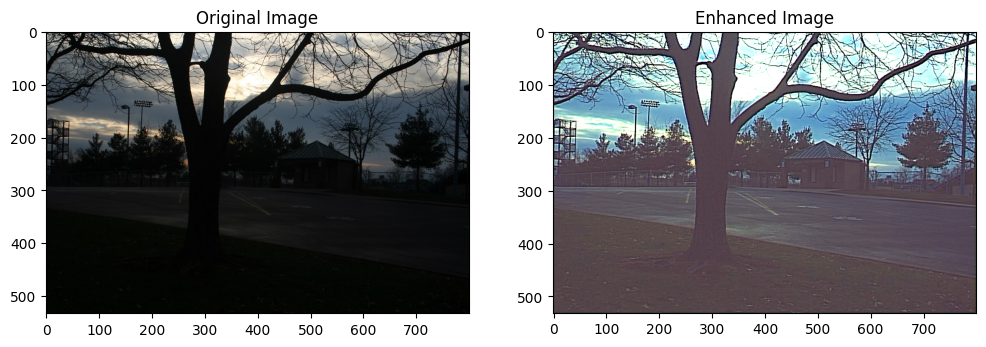

In [ ]:
original_image, output_image = inferer.infer(IMAGE_LOC)
plot_result(original_image, output_image)

In [ ]:
# psnr = psnr(original_image, output_image)

<ipython-input-17-10b76e958d1e>:30: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  (target_width, target_height), Image.ANTIALIAS


1/1 [==============================] - 38s 38s/step


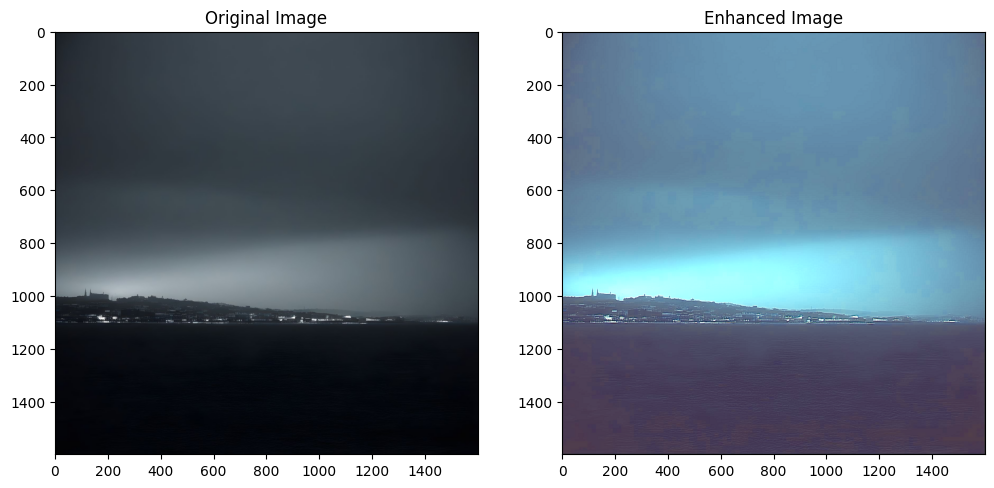

In [ ]:
# sea shore
IMAGE_LOC = '/content/drive/MyDrive/minor/images/image 8.jpg'
original_image, output_image = inferer.infer(IMAGE_LOC)
plot_result(original_image, output_image)
# output_image.save('/content/drive/MyDrive/minor/new_img/image8.jpg')

<ipython-input-17-10b76e958d1e>:30: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  (target_width, target_height), Image.ANTIALIAS


1/1 [==============================] - 3s 3s/step


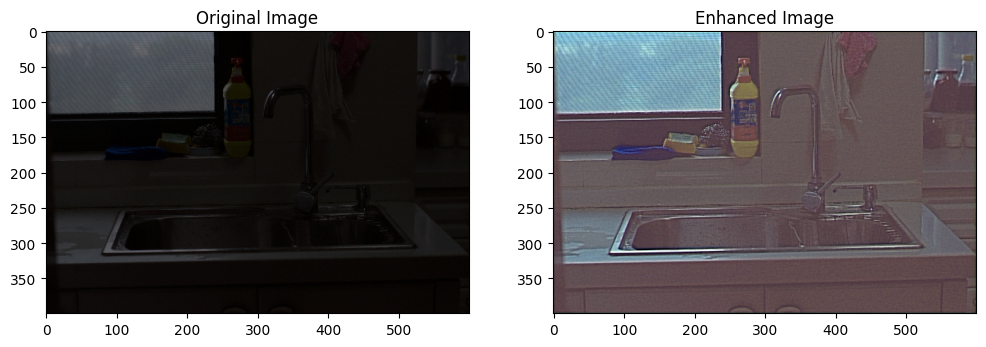

In [ ]:
# kitchen

IMAGE_LOC = '/content/drive/MyDrive/minor/images/75.png'
original_image, output_image = inferer.infer(IMAGE_LOC)
plot_result(original_image, output_image)
# output_image.save('/content/drive/MyDrive/minor/new_img/75.png')

<ipython-input-17-10b76e958d1e>:30: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  (target_width, target_height), Image.ANTIALIAS


1/1 [==============================] - 1s 920ms/step


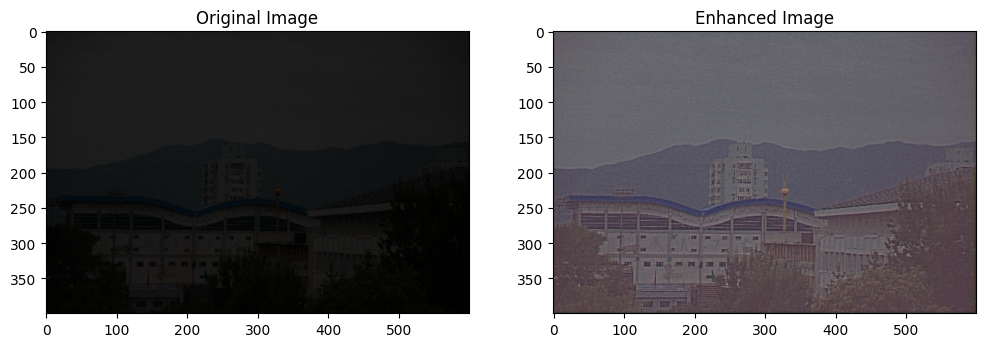

In [ ]:
# building in front of mountain

IMAGE_LOC = '/content/drive/MyDrive/minor/images/570.png'
original_image, output_image = inferer.infer(IMAGE_LOC)
plot_result(original_image, output_image)
# output_image.save('/content/drive/MyDrive/minor/new_img/570.png')

<ipython-input-17-10b76e958d1e>:30: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  (target_width, target_height), Image.ANTIALIAS


1/1 [==============================] - 1s 901ms/step


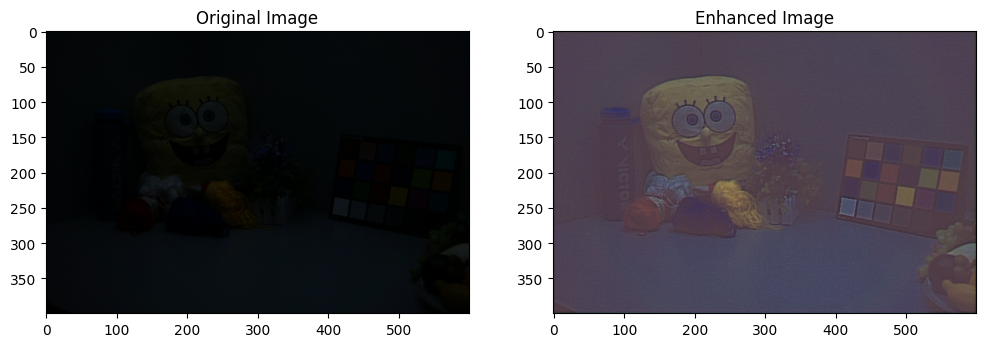

In [ ]:
# spongebob

IMAGE_LOC = '/content/drive/MyDrive/minor/images/474.png'
original_image, output_image = inferer.infer(IMAGE_LOC)
plot_result(original_image, output_image)
# output_image.save('/content/drive/MyDrive/minor/new_img/474.png')

<ipython-input-17-10b76e958d1e>:30: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  (target_width, target_height), Image.ANTIALIAS


1/1 [==============================] - 1s 952ms/step


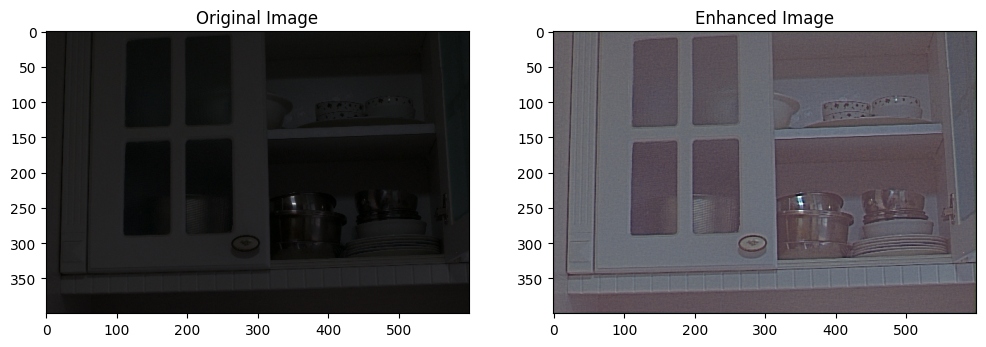

In [ ]:
# kitchen shelf

IMAGE_LOC = '/content/drive/MyDrive/minor/images/79.png'
original_image, output_image = inferer.infer(IMAGE_LOC)
plot_result(original_image, output_image)
# output_image.save('/content/drive/MyDrive/minor/new_img/79.png')

**video enhancement**

In [ ]:
# Additional imports
import cv2
import imutils
from imutils.video import FPS

In [ ]:
# Preprocessing utility
def preprocess_frame(frame):
    frame = Image.fromarray(frame)
    preprocessed_image = frame.resize(
        (
            IMG_WIDTH,
            IMG_HEIGHT
        ),
        Image.ANTIALIAS)
    preprocessed_image = tf.keras.preprocessing.image.img_to_array(preprocessed_image)
    preprocessed_image = preprocessed_image.astype('float32') / 255.0
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)

    return preprocessed_image

In [ ]:
# Load up the model
root = tf.saved_model.load('/content/drive/MyDrive/minor')
concrete_func = root.signatures['serving_default']

In [ ]:
# Warm-up the GPU

IMG_HEIGHT = 128
IMG_WIDTH = 128
for _ in range(100):
    dummy_image = tf.random.normal((1, IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32)
    _ = concrete_func(input_1=dummy_image)["add_171"]
print("GPU warmed up!")

GPU warmed up!


In [ ]:

vs = cv2.VideoCapture("/content/drive/MyDrive/minor/videos/video18.mp4")
writer = None
(W, H) = (None, None)

# Try calculating the total number of frames in the video file
try:
	prop = cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() \
		else cv2.CAP_PROP_FRAME_COUNT
	total = int(vs.get(prop))
	print("[INFO] {} total frames in video".format(total))

# Raise an error if the number of frames couldn't be calculated
except:
	print("[INFO] could not determine # of frames in video")
	print("[INFO] no approx. completion time can be provided")
	total = -1

# Start the FPS throughput estimator
fps = FPS().start()

[INFO] 131 total frames in video


In [ ]:
#@title Real-time inference (takes time)
# loop over frames from the video file stream
while True:
    # read the next frame from the file
    (grabbed, frame) = vs.read()

    # if the frame was not grabbed, then we have reached the end
    # of the stream
    if not grabbed:
        break

    # preprocess the current input frame and run inference
    preprocessed_frame = preprocess_frame(frame)
    enhanced_frame = concrete_func(input_1=preprocessed_frame)["add_171"]

    # post-process the prediction
    enhanced_frame = enhanced_frame.numpy().squeeze() * 255.0
    enhanced_frame = enhanced_frame.clip(0, 255)
    enhanced_frame = enhanced_frame.squeeze()
    enhanced_frame = np.uint8(enhanced_frame)

    # prepare the output frame
    resized_frame = Image.fromarray(frame)
    resized_frame = resized_frame.resize(
        (
            IMG_WIDTH,
            IMG_HEIGHT
        ),
        Image.ANTIALIAS)
    output = np.hstack([np.uint8(resized_frame), enhanced_frame])

    # update the FPS counter
    fps.update()

    # check if the video writer is None
    if writer is None:
        # initialize our video writer
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter("output.avi", fourcc, 30,
            (output.shape[1], output.shape[0]), True)

    # write the output frame to disk
    writer.write(output)

# stop the timer and display FPS information
fps.stop()
print("[INFO] elasped time: {:.2f}".format(fps.elapsed()))
print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

# release the file pointers
print("[INFO] cleaning up...")
writer.release()
vs.release()

<ipython-input-34-6a95915b8868>:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  Image.ANTIALIAS)
<ipython-input-38-d7400b122f7f>:29: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  Image.ANTIALIAS)


[INFO] elasped time: 21.12
[INFO] approx. FPS: 6.20
[INFO] cleaning up...


In [ ]:
!ffmpeg -i "output.avi" output.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
#@title Display video inline
from IPython.display import HTML
from base64 import b64encode

mp4 = open("output.mp4", "rb").read()
dataURL = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=1000 controls>
      <source src="%s" type="video/mp4">
</video>
""" % dataURL)